# Weighted Prediction Error

In [1]:
#!pip install soundfile librosa numpy pyroomacoustics matplotlib tqdm torch torchaudio

In [2]:
import soundfile as sf
import librosa
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from tqdm import tqdm
import requests
import onnxruntime
%matplotlib inline

In [3]:
N_FTT = 512
HOP=128
WIN=512
WINDOW="blackman"
EPS=1e-10
COUNT_OF_FILES = 10

In [4]:
from utils import download_dataset
download_dataset()

Файл уже найден


In [5]:
path_single = Path("./single")
path_single.mkdir(exist_ok=True)

path_reverbed = Path("./single/reverbed")
path_reverbed.mkdir(exist_ok=True)

path_output_mono = Path("./single/output")
path_output_mono.mkdir(exist_ok=True)
print("Созданы директории:single/reverbed, single/output")

Созданы директории:single/reverbed, single/output


In [6]:
current_dir = Path(".")
data = Path("nonblind_test.clean.zip")
with zipfile.ZipFile(data, "r") as zip_ref:
    zip_ref.extractall(current_dir)
print("Архив успешно разархивирован в clean")

Архив успешно разархивирован в clean


In [7]:
from utils import read_normalize, plot_audio_spectrogram
y_clean, sr = read_normalize("clean/fileid_1.flac")
print(y_clean.shape, sr)

(112042,) 16000


## Single channel

In [8]:
def reverb_audio_single(y_clean, sr, plot=False):
    room_dim = [6.0, 4.0, 3]
    rt60 = 0.8
    
    absorption, max_order = pra.inverse_sabine(rt60, room_dim)
    
    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )
    
    src_pos = [5.0, 4, 1.7]
    mic_pos = [2.5, 2, 1.6]
    
    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*')
        ax.scatter(mic_pos[0], mic_pos[1], mic_pos[2],
               color='blue', s=200, marker='^')
        plt.title("Виртуальная комната")
        return None

        
    room.add_source(src_pos, signal=y_clean)
    
    mic = pra.MicrophoneArray(np.c_[mic_pos], room.fs)
    room.add_microphone_array(mic)
    
    room.simulate()
    reverbed = room.mic_array.signals[0]

    if len(reverbed) > len(y_clean):
        reverbed = reverbed[:len(y_clean)]
        
    return reverbed

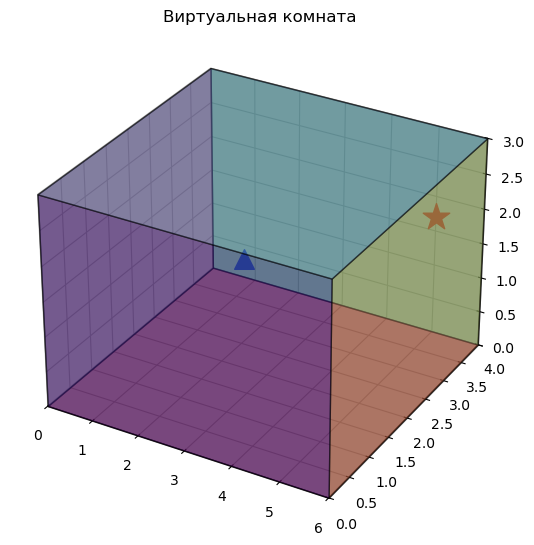

In [9]:
reverb_audio_single(y_clean, sr, plot=True)

In [10]:
y_reverbed = reverb_audio_single(y_clean, sr)
# sf.write(path_reverbed / "test.flac", y_reverbed, sr)

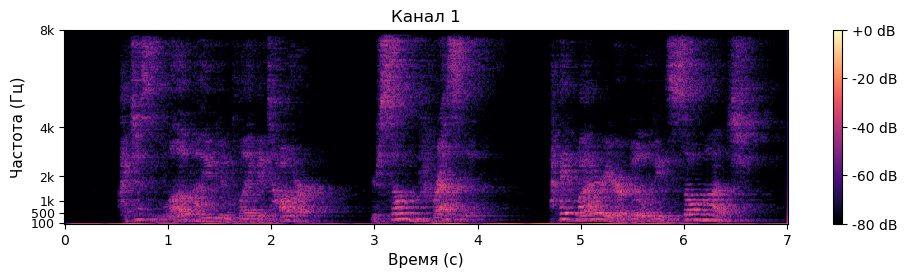

In [11]:
plot_audio_spectrogram(y_reverbed, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [12]:
def moving_avg_power(x, win_len):
    power = np.abs(x)**2
    w = np.ones(win_len, dtype=float) / max(1, win_len)
    return np.convolve(power, w, mode="same")
    
def wpe_mono(
    y, sr,
    n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW, eps=EPS,
    D=3, L=10, N=3, reg=1e-6
):

    Y = librosa.stft(y, n_fft=n_fft, hop_length=hop, win_length=win, window=window)
    F, T = Y.shape
    Z = Y.copy()

    t_min = D + L - 1

    for f in range(F):
        yf = Y[f, :]
        if np.allclose(yf, 0):
            continue

        idx = np.arange(t_min, T)
        if idx.size == 0:
            continue

        X = np.vstack([yf[idx - D - l] for l in range(L)])

        lam_full = np.maximum(moving_avg_power(yf, win_len=L), eps)
        lam = lam_full[idx]

        for _ in range(N):

            A = (X.T) / lam[:, None]
            b = (yf[idx]) / lam

            AH = A.conj().T
            R = AH @ A
            R += reg * np.eye(L, dtype=R.dtype)
            p = AH @ b
            g = np.linalg.solve(R, p)

            pred = (X.conj().T @ g)
            z_valid = yf[idx] - pred

            power_all = np.abs(yf)**2
            power_all[idx] = np.abs(z_valid)**2
            lam_full = np.maximum(moving_avg_power(power_all, win_len=L), eps)
            lam = lam_full[idx]

        Z[f, :t_min] = yf[:t_min]
        Z[f, idx] = z_valid

    y_hat = librosa.istft(Z, hop_length=hop, win_length=win, window=window, length=len(y))
    return y_hat

In [13]:
y_wpe = wpe_mono(y_reverbed, sr, D=3, L=10, N=3)

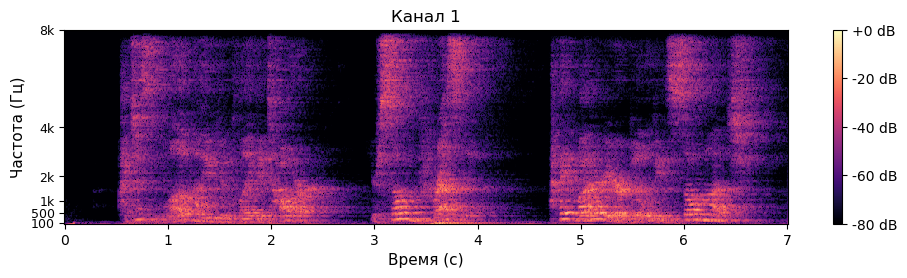

In [14]:
plot_audio_spectrogram(y_wpe, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

# Метрики

In [15]:
from metrics import fwsegsnr, cepstral_distance, DNSMOS
print("Для реверберированного:")
print("FWSegSNR:", fwsegsnr(y_clean, y_reverbed, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_reverbed, sr))
print("DNSMOS:", DNSMOS(y_reverbed, sr))

print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))
print("DNSMOS:", DNSMOS(y_wpe, sr))

Для реверберированного:
FWSegSNR: -12.195629968228404
CD: 114.06910400655349
DNSMOS: [[2.6136441 3.3228066 2.432709 ]]
Для очищенного
FWSegSNR: -2.9515069094049937
CD: 135.5873276151918
DNSMOS: [[1.4747452 1.3707983 1.2577727]]


In [16]:
y_wpe2 = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)
print("Для L = 15")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe2, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_wpe2, sr))
print("DNSMOS:", DNSMOS(y_clean, sr))

Для L = 15
FWSegSNR: -1.9404118194385747
CD: 148.3831218833182
DNSMOS: [[4.016448  4.435159  3.8350701]]


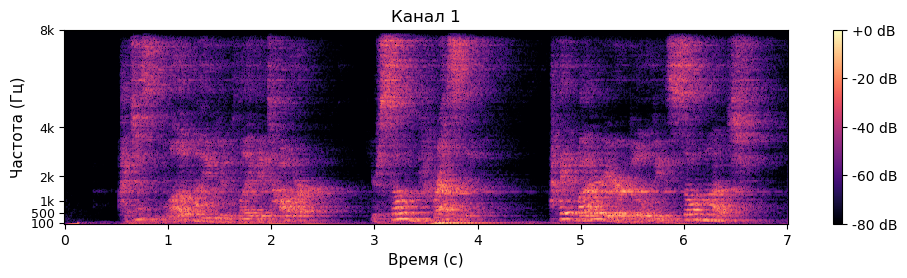

In [17]:
plot_audio_spectrogram(y_wpe2, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

### Ревербирируем датасет и применяем WPE

In [18]:
path_clean = Path("clean")

reverbed_fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
reverbed_cd_metric = np.zeros(COUNT_OF_FILES)
reverbed_dnsmos_metric = np.zeros(COUNT_OF_FILES)

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
dnsmos_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = read_normalize(path_clean / file.name)
    y_reverbed = reverb_audio_single(y_clean, sr)
    y_wpe = wpe_mono(y_reverbed, sr, D=3, L=15, N=3)

    reverbed_fwsegsnr_metric[audio_index] = fwsegsnr(y_reverbed, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW)
    reverbed_cd_metric[audio_index] = cepstral_distance(y_reverbed, y_wpe, sr)
    reverbed_dnsmos_metric[audio_index] = DNSMOS(y_reverbed, sr)[0, 0]

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    dnsmos_metric[audio_index] = DNSMOS(y_wpe, sr)[0, 0]

    audio_index += 1

    sf.write(path_reverbed / file.name, y_reverbed, sr)
    sf.write(path_output_mono / file.name, y_wpe, sr)

In [19]:
print("FWSegSNR")
print("Clean - Reverbed:", np.mean(fwsegsnr_metric - reverbed_fwsegsnr_metric))
print("Mean:", np.mean(fwsegsnr_metric))
print()
print("Cepstral Distance")
print("Clean - Reverbed:", np.mean(cd_metric - reverbed_cd_metric))
print("Mean:", np.mean(cd_metric))
print()
print("DNSMOS")
print("Clean - Reverbed:", np.mean(dnsmos_metric - reverbed_dnsmos_metric))
print("Mean:", np.mean(dnsmos_metric))

FWSegSNR
Clean - Reverbed: -14.764038790278622
Mean: -2.3227637670758097

Cepstral Distance
Clean - Reverbed: 69.00032085278649
Mean: 101.7190245283185

DNSMOS
Clean - Reverbed: -0.16147162914276122
Mean: 1.7762173652648925


## Multi-channel

In [20]:
path_multiple = Path("./multiple")
path_multiple.mkdir(exist_ok=True)

path_output_multi = Path("./multiple/output")
path_output_multi.mkdir(exist_ok=True)
print("Созданы директории: multiple/output")

Созданы директории: multiple/output


In [21]:
import numpy as np
import pyroomacoustics as pra
import matplotlib.pyplot as plt

def reverb_audio_multi(y_clean, sr, plot=False):
    room_dim = [8.0, 6.0, 3.0] 
    rt60 = 0.8

    absorption, max_order = pra.inverse_sabine(rt60, room_dim)

    room = pra.ShoeBox(
        room_dim, fs=sr,
        materials=pra.Material(absorption),
        max_order=max_order
    )

    src_pos = [7.0, 1.0, 1.7]

    mic_center = np.array([2.0, 4.5, 1.6])
    d = 0.5
    num_mics = 5

    mic_positions = np.zeros((3, num_mics))
    for i in range(num_mics):
        mic_positions[:, i] = mic_center + np.array([ \
        d * (i - (num_mics - 1) / 2),
        0.15 * (i - (num_mics - 1) / 2),
        0.0
    ])

    if plot:
        fig, ax = room.plot(img_order=0, figsize=(8, 5))
        ax.scatter(src_pos[0], src_pos[1], src_pos[2],
                   color='red', s=400, marker='*', label='Источник')
        ax.scatter(mic_positions[0, :], mic_positions[1, :], mic_positions[2, :],
                   color='blue', s=200, marker='^', label='Массив микрофонов')
        plt.legend()
        plt.title("Виртуальная комната с 5 микрофонами")
        plt.show()
        return

    room.add_source(src_pos, signal=y_clean)
    room.add_microphone_array(pra.MicrophoneArray(mic_positions, room.fs))

    room.simulate()
    reverbed = room.mic_array.signals

    if len(reverbed) > len(y_clean):
        reverbed = reverbed[:len(y_clean)]
            
    return room.mic_array.signals


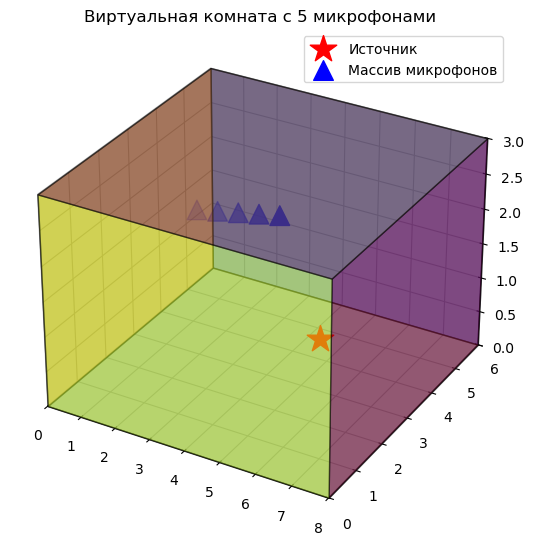

In [22]:
reverb_audio_multi(y_clean, sr, plot=True)

In [23]:
y_reverbed = reverb_audio_multi(y_clean, sr)
# sf.write(path_reverbed / "test.flac", y_reverbed.T, sr)

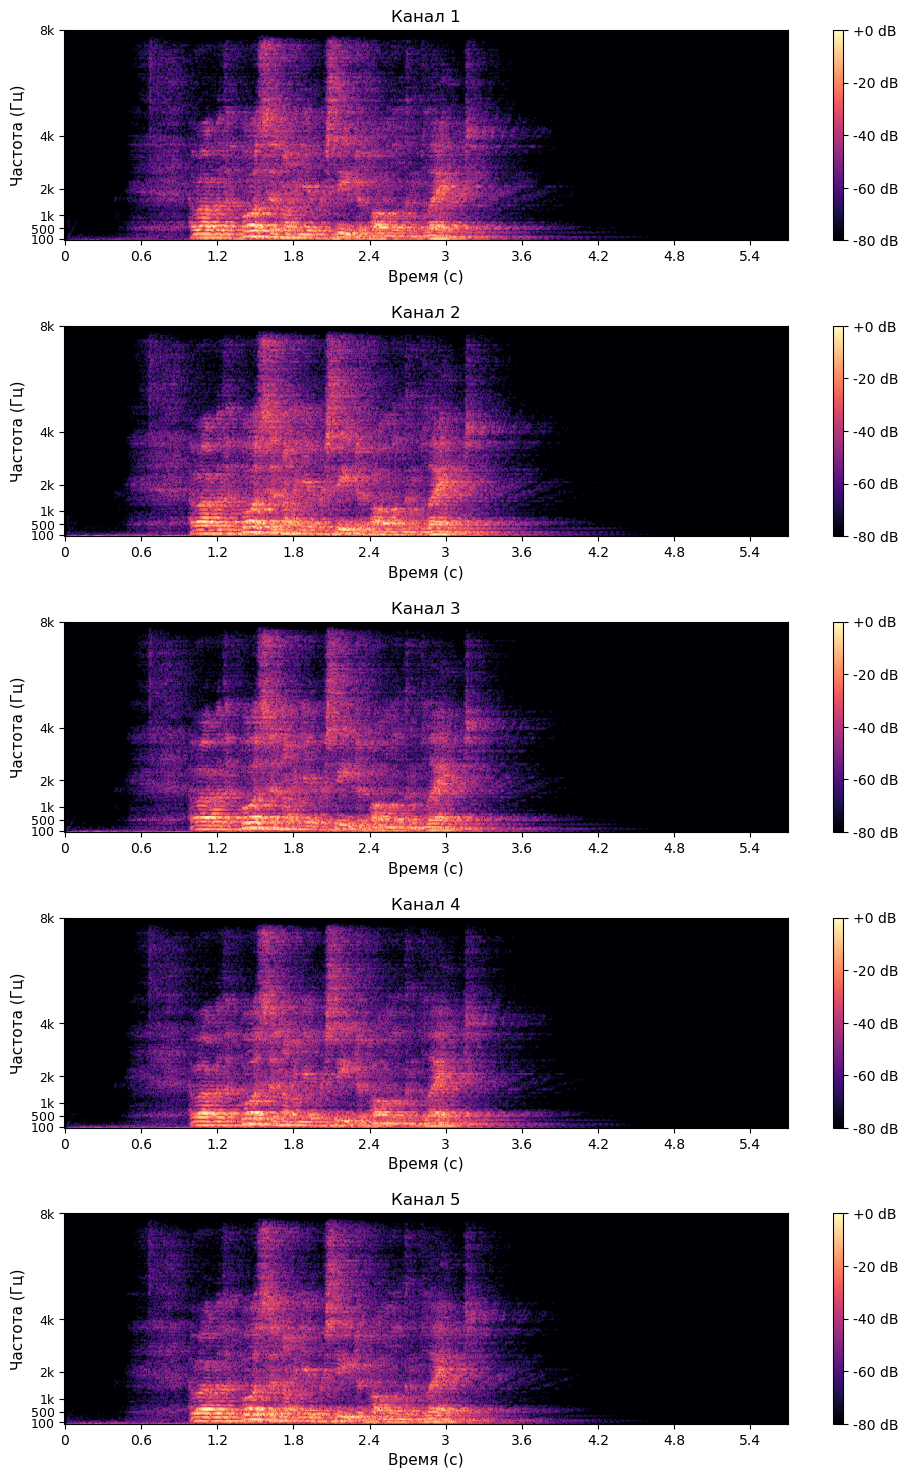

In [24]:
plot_audio_spectrogram(y_reverbed, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [25]:
def wpe_multi(
    y_multi, sr,
    n_fft=1024, hop=256, win=1024, window="hann", eps=1e-9,
    D=3, L=10, N=3, reg=1e-6, ref=0
):

    if y_multi.ndim == 1:
        y_multi = y_multi[None, :]

    M, N_samp = y_multi.shape

    Y_list = []
    for m in range(M):
        Ym = librosa.stft(y_multi[m], n_fft=n_fft, hop_length=hop,
                          win_length=win, window=window)
        Y_list.append(Ym)
    F, T = Y_list[0].shape
    for Yk in Y_list:
        assert Yk.shape == (F, T)
    Y = np.stack(Y_list, axis=0)

    Z_ref = np.zeros((F, T), dtype=Y.dtype)

    t_min = D + L - 1
    if T <= t_min:
        z_hat = librosa.istft(Y[ref], hop_length=hop, win_length=win, window=window, length=N_samp)
        return z_hat

    idx = np.arange(t_min, T)
    T_eff = idx.size
    K = M * L

    for f in range(F):
        Y_f = Y[:, f, :]
        if np.allclose(Y_f, 0):
            Z_ref[f, :] = Y[ref, f, :]
            continue

        X = np.zeros((K, T_eff), dtype=Y.dtype)
        row = 0
        for l in range(L):
            t_idx = idx - D - l
            X[row:row+M, :] = Y_f[:, t_idx]
            row += M

        y_ref = Y_f[ref, :]
        lam_full = np.maximum(moving_avg_power(y_ref, win_len=L), eps)
        lam = lam_full[idx]

        for _ in range(N):
            A = (X.T) / lam[:, None]
            AH = A.conj().T

            b = y_ref[idx] / lam

            R = AH @ A
            R += reg * np.eye(K, dtype=R.dtype)
            p = AH @ b

            g = np.linalg.solve(R, p)

            pred_ref = (X.conj().T @ g)
            z_valid = y_ref[idx] - pred_ref

            power_all = np.abs(y_ref)**2
            power_all[idx] = np.abs(z_valid)**2
            lam_full = np.maximum(moving_avg_power(power_all, win_len=L), eps)
            lam = lam_full[idx]

        Z_ref[f, :t_min] = y_ref[:t_min]
        Z_ref[f, idx]   = z_valid

    y_hat = librosa.istft(Z_ref, hop_length=hop, win_length=win,
                          window=window, length=N_samp)
    return y_hat

In [26]:
y_wpe = wpe_multi(y_reverbed, sr, D=3, L=15, N=3)

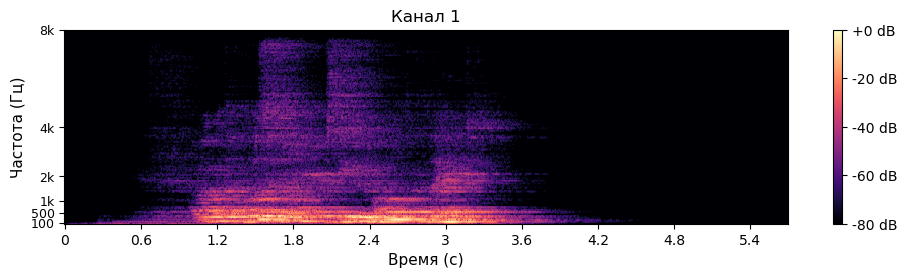

In [27]:
plot_audio_spectrogram(y_wpe, sr, n_fft=N_FTT, hop_length=HOP, win_length=WIN, window=WINDOW)

In [28]:
sf.write(path_output_multi / "test.flac", y_wpe, sr)

In [29]:
print("Для очищенного")
print("FWSegSNR:", fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW))
print("CD:", cepstral_distance(y_clean, y_wpe, sr))
print("DNSMOS:", DNSMOS(y_wpe, sr))

Для очищенного
FWSegSNR: -8.88663179313935
CD: 121.454039866955
DNSMOS: [[2.0128384 2.7541435 1.8129959]]


In [ ]:
path_clean = Path("clean")

reverbed_fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
reverbed_cd_metric = np.zeros(COUNT_OF_FILES)
reverbed_dnsmos_metric = np.zeros(COUNT_OF_FILES)

fwsegsnr_metric = np.zeros(COUNT_OF_FILES)
cd_metric = np.zeros(COUNT_OF_FILES)
dnsmos_metric = np.zeros(COUNT_OF_FILES)
audio_index = 0

clean_audio = [f for f in path_clean.iterdir() if f.is_file()][0: COUNT_OF_FILES]

for file in clean_audio:
    y_clean, sr = read_normalize(path_clean / file.name)
    y_reverbed = reverb_audio_multi(y_clean, sr)
    y_wpe = wpe_multi(y_reverbed, sr, D=3, L=15, N=3)

    fwsegsnr_metric[audio_index] = fwsegsnr(y_clean, y_wpe, sr, eps=EPS, n_fft=N_FTT, hop=HOP, win=WIN, window=WINDOW)
    cd_metric[audio_index] = cepstral_distance(y_clean, y_wpe, sr)
    dnsmos_metric[audio_index] = DNSMOS(y_wpe, sr)[0, 0]
    audio_index += 1
    
    sf.write(path_output_multi / file.name, y_wpe, sr)

In [ ]:
print("FWSegSNR")
print("Clean - Reverbed:", np.mean(fwsegsnr_metric - reverbed_fwsegsnr_metric))
print("Mean:", np.mean(fwsegsnr_metric))
print()
print("Cepstral Distance")
print("Clean - Reverbed:", np.mean(cd_metric - reverbed_cd_metric))
print("Mean:", np.mean(cd_metric))
print()
print("DNSMOS")
print("Clean - Reverbed:", np.mean(dnsmos_metric - reverbed_dnsmos_metric))
print("Mean:", np.mean(dnsmos_metric))